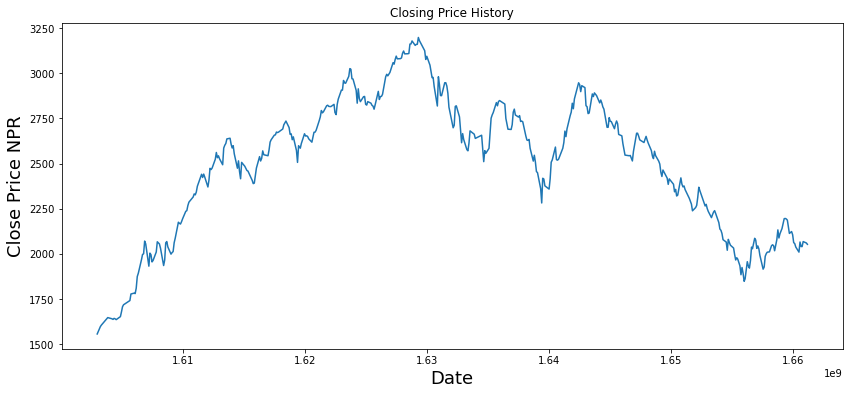

[array([0.        , 0.00827348, 0.01632762, 0.024924  , 0.0301269 ,
       0.05522758, 0.05414313, 0.05126752, 0.04924485, 0.05253474,
       0.05107866, 0.04835536, 0.05591602, 0.05848701, 0.07432115,
       0.091916  , 0.09850797, 0.11271544, 0.13483694, 0.13769427,
       0.13624428, 0.15432652, 0.19374433, 0.20497261, 0.25068387,
       0.26821779, 0.27025874, 0.31328325, 0.30379739, 0.22865376,
       0.27268961, 0.26718208, 0.24305619, 0.2480946 , 0.2763816 ,
       0.31093768, 0.30742846, 0.30365727, 0.28982143, 0.23079829,
       0.24927653, 0.30742846, 0.31171751, 0.29354998, 0.26919257,
       0.27445641, 0.27786815, 0.30782447, 0.3231834 , 0.3768696 ,
       0.37300093, 0.37083813, 0.37880699, 0.38849999, 0.41362504,
       0.41587922, 0.4331268 , 0.4445866 , 0.46192556, 0.4724715 ,
       0.46917552, 0.47883806, 0.49826062, 0.52884446, 0.53861057,
       0.52777829, 0.53920762, 0.52911861, 0.49576274, 0.51873108])]
[0.5586301853916498]

[array([0.        , 0.00827348, 0.016

In [4]:
import numpy as np
import math as math
import pandas as pd
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import json
from datetime import timedelta, datetime
import mysql.connector
from sqlalchemy import create_engine

#import all these libraries



#creating connection
db = mysql.connector.connect(host='localhost', user='root', database='stock')
cursor = db.cursor(buffered=True)


sql = f"select * from historic"
cursor.execute(sql)
result = cursor.fetchall()


#prediction starts

df = pd.DataFrame(data = result, columns=['Date','Close','Open','High','Low','Volume'])

df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Volume'] = df['Volume'].astype(float)

df2 = df.set_index('Date')
df2


df3=df2[['Close']]
df3



plt.figure(figsize=(14,6))
plt.title('Closing Price History')
plt.plot(df3['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price NPR', fontsize=18)
plt.show()


data = df3.filter(['Close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) * .7 )
training_data_len


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data


train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []
for i in range(70, len(train_data)):
    x_train.append(train_data[i-70:i, 0])
    y_train.append(train_data[i, 0])
    if i<=71:
        print(x_train)
        print(y_train)
        print()


x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=5, epochs=50)


test_data = scaled_data[training_data_len - 70: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(70, len(test_data)):
    x_test.append(test_data[i-70:i, 0])


x_test = np.array(x_test)


x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse




new_df = df3.filter(['Close'])
last_70_days = new_df[-70:].values
last_70_days_scaled = scaler.transform(last_70_days)
X_test = []
X_test.append(last_70_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

#yaa bata gareko bujhdainas taile chodde vai
int_price = pred_price[0][0]
int_price1 = format(int_price, ".2f")

price = float(int_price1)

today_price = df3.tail(1)
result = today_price.to_string(index = False)

#today = datetime.today()
#today_date = today.strftime("%Y/%m/%d")
#today = datetime.now() # get date and time today
#delta = timedelta(days=1) #initialize delta
#date = today + delta # add the delta days
#tomorrow_date = date("%Y/%m/%d") # format it



predictions = pd.DataFrame(predictions)
predictions.columns =['Prediction']
predictions['Prediction'] = predictions['Prediction'].astype(float)

last_thirty_df = df.loc[len(df)-len(df)*0.3:len(df),['Date','Close']]
last_thirty_df.reset_index(drop=True,inplace=True)
final_df = pd.concat([last_thirty_df,predictions],axis=1,join='inner')


final_df.loc[i] = ['0','0',price]


final_df['Scrip'] = 'Nepse'
final_df = final_df[['Scrip','Date','Close','Prediction']]
engine = create_engine('mysql+mysqlconnector://root:@localhost:3306/stock')

#table and columns aafai bancha banaunu pardaina
final_df.to_sql(name='historic_predictions', con=engine, if_exists = 'append', index=False)

In [ ]:
predictions.columns

In [ ]:
model1 = Sequential()
model1.add(GRU(100, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model1.add(GRU(100, return_sequences=False))
model1.add(Dense(25))
model1.add(Dense(1))


model1.compile(optimizer='adam', loss='mean_squared_error')

model1.fit(x_train, y_train, batch_size=5, epochs=50)


test_data1 = scaled_data[training_data_len - 70: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(70, len(test_data)):
    x_test.append(test_data[i-70:i, 0])


x_test = np.array(x_test)


x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse




new_df = df3.filter(['Close'])
last_70_days = new_df[-70:].values
last_70_days_scaled = scaler.transform(last_70_days)
X_test = []
X_test.append(last_70_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

#yaa bata gareko bujhdainas taile chodde vai
int_price = pred_price[0][0]
int_price1 = format(int_price, ".2f")

price = float(int_price1)

today_price = df3.tail(1)
result = today_price.to_string(index = False)

#today = datetime.today()
#today_date = today.strftime("%Y/%m/%d")
#today = datetime.now() # get date and time today
#delta = timedelta(days=1) #initialize delta
#date = today + delta # add the delta days
#tomorrow_date = date("%Y/%m/%d") # format it



predictions = pd.DataFrame(predictions)
predictions.columns =['Prediction']
predictions['Prediction'] = predictions['Prediction'].astype(float)

last_thirty_df = df.loc[len(df)-len(df)*0.3:len(df),['Date','Close']]
last_thirty_df.reset_index(drop=True,inplace=True)
final_df = pd.concat([last_thirty_df,predictions],axis=1,join='inner')


final_df.loc[i] = ['0','0',price]


final_df['Scrip'] = 'Nepse'
final_df = final_df[['Scrip','Date','Close','Prediction']]